### <변수참조> https://dacon.io/competitions/official/235701/talkboard/402550?page=1&dtype=recent&ptype=pub
- L/R ear : 양쪽 귀의 중앙 부분을 선택, viewpoint에 따라 한 쪽 귀만 보일수 있는데, 보이지 않는 귀는 표시하지 않음
- L/R eye : 양 눈의 중앙 부분을 선택, 측면에서는 실제 눈이 위차할 법한 안쪽을 택하여 작성. 뒷 모습에는 작성하지 않음
- nose : 콧망울의 중앙을 표기한다는 느낌으로 작성. 측면인 경우도 콧망울 덩어리의 중앙을 목표로 하여 작성
- neck : 겉에서 보이는 목울대가 아닌, 목을 일종의 원기둥으로 생각했을 때 중앙 부분을 표시
- back : 어깨와 엉덩이 사이를 셋으로 나누어, 어깨에서부터 약 1/2 내분점 위치. 양 날개뼈 끝쪽에 위치한 등뼈 중앙 부분을 표시. 정면에서도 위치를 추정하여 표시
- waist : 어깨와 엉덩이 사이를 셋으로 나누어, 어깨에서부터 약 1/2 내분점 위치. 허리를 짚는다 정도의 높이, 몸통 가운데 부분을 표시. 정면에서도 위치를 추정하여 표시
- L/R Shoulder : 어깨를 이루는 관절을 일종의 구로 생각했을 때, 그 구체의 중심 위치를 찍는다는 생각으로 표시
- L/R Elbow : 팔꿈치 관절을 관절을 일종의 구로 생각했을 때, 그 구체의 중심 위치를 찍는다는 생각으로 표시
- L/R Wrist : 손목의 중앙 부분을 표시
- L/R Palm : 손바닥 또는 손등의 중앙 부분을 표시. 손날이 보이는 경우는 손날의 중심을 표시
- L/R Hip : 엉덩이의 중심부 중앙에 표시. 측면의 경우 보이는 쪽만 표시하여도 무방
- L/R Knee : 무릎 관절 중앙에 표시. 후면의 경우 관절 안쪽의 중앙에 표시
- L/R Ankle : 정면의 경우 발목이 접히는 위치 중앙, 측면의 경우 복사뼈, 후면의 경우 아킬레스건 위치에 표시
- L/R Instep : 발바닥 중심에 표시. 전면의 경우 발 중앙 하단부, 측면의 경우 측면 중앙 하단부에 표시

# Library Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
import os
import cv2

from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, Input, Flatten, Dense
from tensorflow.keras import Model

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 불러오고 살펴보기 

In [ ]:
d_path = '/content/drive/MyDrive/Colab Notebooks/pkg/dl_exam/Dacon1/'
train = pd.read_csv(d_path + 'train_df.csv')
submission = pd.read_csv(d_path + 'sample_submission.csv')

train.head(2)

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,001-1-1-01-Z17_A-0000001.jpg,1046.389631,344.757881,1041.655294,329.820225,1059.429507,334.48423,1020.117796,338.890539,1048.000000,343.000000,992.0,394.0,1054.0,400.0,956.0,368.0,1134.0,371.0,1003.497242,327.640085,1078.0,341.0,999.0,570.0,1046.0,573.0,995.0,695.0,1054.0,698.0,983.000000,820.000000,1042.0,829.0,1019.107277,373.766222,1013.137360,316.311695,1067.00000,335.0,1019.484230,455.000000,1026.515770,514.054730,998.578836,826.718013,1063.204067,838.827465
1,001-1-1-01-Z17_A-0000003.jpg,1069.850679,340.711494,1058.608552,324.593690,1075.242111,325.59369,1041.422997,331.694815,1065.593682,333.968459,1010.0,398.0,1077.0,386.0,974.0,398.0,1144.0,337.0,1004.000000,346.000000,1094.0,326.0,1020.0,557.0,1069.0,567.0,1013.0,583.0,1072.0,697.0,1003.843781,678.797029,1042.0,829.0,1047.279440,362.031898,1017.383112,332.890539,1081.18738,323.0,1046.953248,454.062706,1058.766231,508.797029,1002.265676,699.062706,1066.376234,841.499445


In [ ]:
train.shape

(4195, 49)

In [ ]:
#submission 파일 불러오기
submission.head(2)

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,649-2-4-32-Z148_A-0000001.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,649-2-4-32-Z148_A-0000003.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


많은 파일들을 다뤄야 하는 파이썬 프로그램을 작성할 때, 특정한 패턴이나 확장자를 가진 파일들의 경로나 이름이 필요할 때가 있다. glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다. 단, 조건에 정규식을 사용할 수 없으며 엑셀 등에서도 사용할 수 있는 '*'와 '?'같은 와일드카드만을 지원한다.

In [34]:
#glob를 활용해 이미지의 경로들을 불러옵니다.
import glob
train_paths = sorted(glob.glob(d_path + './train_imgs/*.jpg'))   # 현재 디렉터리의 .jpg 파일
test_paths = sorted(glob.glob(d_path + './test_imgs/*.jpg'))
print(len(train_paths), len(test_paths))

4195 1600


### CSV에서는 image명이 정렬되어 있는데, train_paths가 가져올 때는 이미지 이름에 따라서 정렬이 안되서 미스매칭! >>그래서 sorted로 정렬

# 시각화

주어진 이미지와 keypoint지점을 비교해보며 데이터에 대한 이해도를 높여봐요!

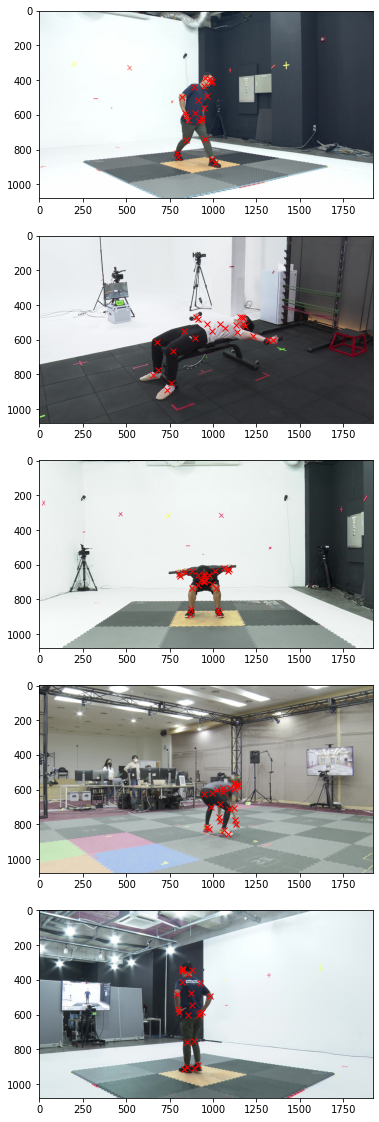

In [35]:
plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(train_paths),5):
    
    plt.subplot(5,1, count)
    
    img_sample_path = train_paths[i]
    img = Image.open(img_sample_path)
    img_np = np.array(img)

    keypoint = train.iloc[:,1:49] #위치키포인트 하나씩 확인
    keypoint_sample = keypoint.iloc[i, :]
    
    for j in range(0,len(keypoint.columns),2):
        plt.plot(keypoint_sample[j], keypoint_sample[j+1],'rx')
        plt.imshow(img_np)
    
    count += 1


# 모델링

### CNN을 이용하여 MAXPooling 확인

In [ ]:
train['path'] = train_paths

대용량 이미지를 불러올 때 Generator 를 활용해서 불러옵니다.

In [ ]:
def trainGenerator():
    for i in range(len(train)):
        img = tf.io.read_file(train['path'][i]) # path(경로)를 통해 이미지 읽기
        img = tf.image.decode_jpeg(img, channels=3) # 경로를 통해 불러온 이미지를 tensor로 변환
        img = tf.image.resize(img, [180,320]) # 이미지 resize 
        target = train.iloc[:,1:49].iloc[i,:] # keypoint 뽑아주기
        
        yield (img, target)

# generator를 활용해 데이터셋 만들기        
train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float64, tf.float64), (tf.TensorShape([180,320,3]),tf.TensorShape([48])))
train_dataset = train_dataset.batch(32).prefetch(1)

In [ ]:
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
# 간단한 CNN 모델을 적용합니다.
## 여기 수정, early_stopping추가

# model = Sequential()
#                       # filters, kernel_size
# model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(180,320,3)))
# model.add(LeakyReLU(alpha = 0.1))
# model.add(BatchNormalization())    # overfiiting을 피하기 위한 방법 중 하나

# model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
# model.add(LeakyReLU(alpha = 0.1))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))

# model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
# model.add(LeakyReLU(alpha = 0.1))
# model.add(BatchNormalization())

# model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
# model.add(LeakyReLU(alpha = 0.1))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))

# model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
# model.add(LeakyReLU(alpha = 0.1))
# model.add(BatchNormalization())

# model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
# model.add(LeakyReLU(alpha = 0.1))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))


# model.add(Flatten())
# model.add(Dense(512,activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(48))


#------------------------------------------------------------------------------

model = Sequential()
                      # filters, kernel_size
model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(180,320,3)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())    # overfiiting을 피하기 위한 방법 중 하나

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(7, 7)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512,activation='relu'))    # dense 들어가는 거 찾자
# model.add(Dense(256,activation='relu'))
# model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(48))
print(model.summary()) 

In [ ]:
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mae'])

In [ ]:
model.fit(train_dataset, epochs = 100, verbose=1, callbacks=[early_stop])

Epoch 1/10
132/132 [==============================] - 1180s 9s/step - loss: 18915.1406 - mae: 104.4751
Epoch 2/10
132/132 [==============================] - 1179s 9s/step - loss: 19238.0273 - mae: 105.8550
Epoch 3/10
132/132 [==============================] - 1178s 9s/step - loss: 19116.9805 - mae: 105.4229
Epoch 4/10
132/132 [==============================] - 1173s 9s/step - loss: 19123.8008 - mae: 105.6484
Epoch 5/10
132/132 [==============================] - 1164s 9s/step - loss: 19094.7910 - mae: 105.2906
Epoch 6/10
132/132 [==============================] - 1161s 9s/step - loss: 19153.9004 - mae: 105.5242
Epoch 7/10
132/132 [==============================] - 1161s 9s/step - loss: 19055.4688 - mae: 105.3866
Epoch 8/10
132/132 [==============================] - 1160s 9s/step - loss: 18983.4922 - mae: 105.2214
Epoch 9/10
132/132 [==============================] - 1157s 9s/step - loss: 18898.2734 - mae: 104.8858
Epoch 10/10
132/132 [==============================] - 1156s 9s/step - lo

# test 데이터

In [ ]:
X_test=[]

for test_path in tqdm(test_paths):
    img=tf.io.read_file(test_path)
    img=tf.image.decode_jpeg(img, channels=3)
    img=tf.image.resize(img, [180,320])
    X_test.append(img)

100%|██████████| 1600/1600 [00:19<00:00, 82.40it/s]


In [ ]:
X_test=tf.stack(X_test, axis=0)
X_test.shape

TensorShape([1600, 180, 320, 3])

In [ ]:
pred=model.predict(X_test)

# 제출하기

In [ ]:
submission.iloc[:,1:]= pred

In [ ]:
submission

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,649-2-4-32-Z148_A-0000001.jpg,910.795532,528.138184,912.221130,516.874146,907.817017,517.430298,914.892700,507.239746,923.880066,509.382935,945.125977,524.113586,945.225708,515.042664,934.299194,549.681885,946.772339,554.877625,911.055725,603.099426,947.241638,594.745728,1022.892517,582.915039,1026.412231,583.997437,1064.084106,677.318359,1070.567627,680.268860,1099.693481,723.937927,1097.551270,727.140442,936.160400,528.973694,913.660767,620.242920,931.749512,607.581543,965.355164,544.555237,1006.690125,591.851685,1113.104126,750.833679,1119.416626,753.352295
1,649-2-4-32-Z148_A-0000003.jpg,878.034180,483.883026,859.756714,489.734375,863.526367,499.603790,864.168396,469.851929,881.402466,477.564758,885.106018,483.138428,903.219421,472.368866,864.584045,508.442596,916.191711,509.496826,849.102539,567.631775,908.097046,564.655029,949.384155,538.407593,955.292908,539.745972,975.833008,625.708923,983.338013,627.689697,1002.351746,672.311096,1010.395203,684.466492,899.701233,481.578705,863.010010,574.257446,917.481689,562.868408,922.888367,470.354675,953.767517,536.205811,1029.154419,695.585815,1042.171387,695.360046
2,649-2-4-32-Z148_A-0000005.jpg,908.557800,503.921967,887.404419,510.670227,892.348755,519.929932,892.423340,489.056091,907.750366,497.020233,914.498718,501.594177,930.197327,491.929291,893.688049,527.035522,943.313599,528.153381,877.400513,590.439148,934.542969,587.586548,981.081848,556.439209,986.395142,558.028259,1010.250000,647.502747,1017.688965,649.319824,1038.184570,693.307068,1044.618774,707.142639,928.832275,501.245026,892.336792,596.389038,946.653809,584.763184,953.050354,486.136108,984.636414,554.673096,1066.996216,718.172485,1078.492920,717.923828
3,649-2-4-32-Z148_A-0000007.jpg,909.961121,524.666931,911.492188,515.078247,905.121582,515.799622,914.313477,507.724030,921.025391,507.802795,944.527710,524.470581,942.998596,514.296143,933.430725,550.194519,942.149353,555.775635,908.925354,607.363342,942.054565,598.182861,1022.187683,585.944824,1025.012939,586.599976,1064.901978,681.114441,1070.605713,683.348145,1098.185425,728.851624,1096.831543,731.216736,934.828125,525.560486,914.537598,621.962158,928.118530,609.445190,965.661560,543.184021,1006.400818,591.923401,1114.277100,755.128784,1119.034302,756.130493
4,649-2-4-32-Z148_A-0000009.jpg,882.902283,485.167694,861.614380,492.283997,866.598206,502.104462,865.945679,471.053101,885.152466,480.523376,886.540771,485.742371,907.088745,474.176666,866.236328,509.542084,921.020630,510.596008,851.870300,566.780518,911.695557,564.677917,950.567078,538.838379,957.447449,540.376282,976.241516,627.688416,984.388123,628.531982,1002.169312,672.706543,1010.087952,683.481995,901.702393,483.827698,865.562744,572.358215,923.062439,562.267822,925.165466,470.948914,956.299988,538.167236,1028.892090,694.839661,1042.057617,693.993774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,786-3-5-41-Z94_E-0000023.jpg,813.108215,476.149567,813.011719,470.221649,815.711914,477.724213,816.327393,457.731201,817.192871,455.032562,829.855896,465.576874,840.562988,457.758331,814.356201,494.496246,849.729370,495.112305,792.372742,553.200867,830.691040,549.079468,878.940125,506.663910,878.877991,503.115967,906.050842,576.164490,913.8

In [ ]:
# submission.to_csv('baseline_submission.csv', index=False)
submission.to_csv(d_path + 'test_submission.csv', index=False)